In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None #make all columns visible when printing the dataframe

- I will only use "train.csv" data for this notebook and split it into train and test sets for model validation, since "test.csv" data from Kaggle does not have target variables.

# 1) Data Reading
- Read dataset and print dataset information

In [2]:
delivery_data = pd.read_csv("train.csv", encoding="utf-8")
delivery_data.head()

ID Delivery_person_ID Delivery_person_Age Delivery_person_Ratings  \
0  0x4607     INDORES13DEL02                   37                     4.9   
1  0xb379     BANGRES18DEL02                   34                     4.5   
2  0x5d6d     BANGRES19DEL01                   23                     4.4   
3  0x7a6a    COIMBRES13DEL02                   38                     4.7   
4  0x70a2     CHENRES12DEL01                   32                     4.6   

   Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0            22.745049             75.892471                   22.765049   
1            12.913041             77.683237                   13.043041   
2            12.914264             77.678400                   12.924264   
3            11.003669             76.976494                   11.053669   
4            12.972793             80.249982                   13.012793   

   Delivery_location_longitude  Order_Date Time_Orderd Time_Order_picked  \
0                    75.912471  19-03-2022    11:30:00          11:45:00   
1                    77.813237  25-03-2022    19:45:00          19:50:00   
2                    77.688400  19-03-2022    08:30:00          08:45:00   
3                    77.026494  05-04-2022    18:00:00          18:10:00   
4                    80.289982  26-03-2022    13:30:00          13:45:00   

       Weatherconditions Road_traffic_density  Vehicle_condition  \
0       conditions Sunny                High                   2   
1      conditions Stormy                 Jam                   2   
2  conditions Sandstorms                 Low                   0   
3       conditions Sunny              Medium                   0   
4      conditions Cloudy                High                   1   

  Type_of_order Type_of_vehicle multiple_deliveries Festival            City  \
0        Snack      motorcycle                    0      No           Urban    
1        Snack         scooter                    1      No   Metropolitian    
2       Drinks      motorcycle                    1      No           Urban    
3       Buffet      motorcycle                    1      No   Metropolitian    
4        Snack         scooter                    1      No   Metropolitian    

  Time_taken(min)  
0        (min) 24  
1        (min) 33  
2        (min) 26  
3        (min) 21  
4        (min) 30

In [3]:
delivery_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  object 
 3   Delivery_person_Ratings      45593 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio

# 2) Data Cleaning
- Clean target and feature variables from unnecesarry information 
- Handle NaN values

In [4]:
'''
Remove "min" string from target variable and get numerical target
'''

delivery_data["Time_taken(min)"] = delivery_data["Time_taken(min)"].apply(lambda x: x[len("(min) "):]).astype(int)
delivery_data.rename(columns={"Time_taken(min)" : "delivery_time_taken"},inplace=True)

In [5]:
delivery_data["Weatherconditions"].unique()

array(['conditions Sunny', 'conditions Stormy', 'conditions Sandstorms',
       'conditions Cloudy', 'conditions Fog', 'conditions Windy',
       'conditions NaN'], dtype=object)

- Weather conditions feature contians string "NaN" values that we should convert to Null values

In [6]:
'''
Remove "conditions" string from weather conditions feature and convert string "NaN" values to np.nan
'''

delivery_data["Weatherconditions"] = delivery_data["Weatherconditions"].apply(lambda x: x[len("conditions "):])
delivery_data["Weatherconditions"].replace("NaN", np.nan, inplace=True)


In [7]:
delivery_data.isna().sum()

ID                               0
Delivery_person_ID               0
Delivery_person_Age              0
Delivery_person_Ratings          0
Restaurant_latitude              0
Restaurant_longitude             0
Delivery_location_latitude       0
Delivery_location_longitude      0
Order_Date                       0
Time_Orderd                      0
Time_Order_picked                0
Weatherconditions              616
Road_traffic_density             0
Vehicle_condition                0
Type_of_order                    0
Type_of_vehicle                  0
multiple_deliveries              0
Festival                         0
City                             0
delivery_time_taken              0
dtype: int64

- Other features do not contain object Null values so we should investiage if they have string "NaN" values or not

In [8]:
print(delivery_data["Road_traffic_density"].unique())

['High ' 'Jam ' 'Low ' 'Medium ' 'NaN ']


In [9]:
'''
It seems "NaN" strings have a space after them, convert both "NaN " and "NaN" to object Null values
'''

delivery_data.replace("NaN ", np.nan, inplace=True)
delivery_data.replace("NaN", np.nan, inplace=True)

delivery_data.isna().sum()

ID                                0
Delivery_person_ID                0
Delivery_person_Age            1854
Delivery_person_Ratings        1908
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    1731
Time_Order_picked                 0
Weatherconditions               616
Road_traffic_density            601
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries             993
Festival                        228
City                           1200
delivery_time_taken               0
dtype: int64

- We should handle Null values. I will use imputation beacuse not want to lose any information

    > Mean imputation for numerical variables and mode imputation for categorical variables seems proper for this dataset
    >> "Time_Orderd" NaN's will replace with rows "Time_Order_picked" since it is a date variable

In [10]:
from sklearn.impute import SimpleImputer

mean_cols = ["Delivery_person_Age", "Delivery_person_Ratings"]

mode_cols = ["Weatherconditions", "Road_traffic_density", 
             "multiple_deliveries", "Festival", "City"]

mean_imp = SimpleImputer(missing_values=np.nan, strategy='mean')

for col in mean_cols:
    delivery_data[col] = mean_imp.fit_transform(delivery_data[col].to_numpy().reshape(-1,1))

mode_imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

for col in mode_cols:
    delivery_data[col] = mode_imp.fit_transform(delivery_data[col].to_numpy().reshape(-1,1))

delivery_data["Time_Orderd"] = delivery_data["Time_Orderd"].fillna(delivery_data["Time_Order_picked"])

In [11]:
delivery_data.isna().sum()

ID                             0
Delivery_person_ID             0
Delivery_person_Age            0
Delivery_person_Ratings        0
Restaurant_latitude            0
Restaurant_longitude           0
Delivery_location_latitude     0
Delivery_location_longitude    0
Order_Date                     0
Time_Orderd                    0
Time_Order_picked              0
Weatherconditions              0
Road_traffic_density           0
Vehicle_condition              0
Type_of_order                  0
Type_of_vehicle                0
multiple_deliveries            0
Festival                       0
City                           0
delivery_time_taken            0
dtype: int64

# 3) Feature Generation & Explarotary Data Analysis
- Extract new features from existing features to enrich the dataset
- Visualize how delivery time changes w.r.t features
- Examine the relationships of features over delivery time

### a) Generate New Features

In [12]:
import geopy.distance

def calculate_dist(la1,lo1,la2,lo2):

        '''
        Calculate distance between restaurant and delivery point by using coordinates
        '''

        return geopy.distance.geodesic((abs(la1),abs(lo1)), (abs(la2),abs(lo2))).km

delivery_data["distance"] = delivery_data[["Restaurant_latitude", "Restaurant_longitude", 
                         "Delivery_location_latitude", "Delivery_location_longitude"]].apply(lambda x: calculate_dist(*x), axis=1)

delivery_data = delivery_data.drop(["Restaurant_latitude", "Restaurant_longitude", 
                         "Delivery_location_latitude", "Delivery_location_longitude"], axis=1)

In [13]:
def prep_time(df):
    
    '''
    Convert order time and order_picked times to datetime objects and extract time information and calculate preperation time
    '''

    df["order_datetime"] = pd.to_datetime(df["Order_Date"] + ' ' + df["Time_Orderd"], dayfirst=True)
    df["picked_datetime"] = pd.to_datetime(df["Order_Date"] + ' ' + df["Time_Order_picked"], dayfirst=True)

    df = df.drop(["Order_Date", "Time_Orderd", "Time_Order_picked"], axis=1)

    df["ordered_hour"] = df["order_datetime"].apply(lambda x: x.hour)
    df["ordered_min"] = df["order_datetime"].apply(lambda x: x.minute)

    df["picked_hour"] = df["picked_datetime"].apply(lambda x: x.hour)
    df["picked_min"] = df["picked_datetime"].apply(lambda x: x.minute)

    def calc_prep_time(ord_hour, ord_min, pc_hour, pc_min):
        
        '''
        Calculating order preperation times. Careful about:
            - orders given before hour 24 and picked after hour 24
            - order preperation times bigger than 60 minutes
        '''
        
        if ord_hour == pc_hour:
            if pc_min > ord_min:
                return pc_min - ord_min
            else:
                return 0

        else:
            return 60 - ord_min + pc_min

    df["prep_min"] = df.iloc[:,-4:].apply(lambda x: calc_prep_time(*x), axis=1)
    
    return df

delivery_data = prep_time(delivery_data)

In [14]:
def create_date_intervals(df):
    
    '''
    Create date intervals as; is weekend or not, periods of month and quarters of year
    '''

    df["is_weekend"] = delivery_data["order_datetime"].dt.day_of_week > 4

    df["month_intervals"] = df["order_datetime"].apply(lambda x: "start_month" if x.day <=10 
                                                   else ("middle_month" if x.day <= 20 else "end_month"))

    df["year_quarter"] = df["order_datetime"].apply(lambda x: x.quarter)

    return df

delivery_data = create_date_intervals(delivery_data)

Check duplicates

In [15]:
delivery_data.duplicated().sum()

0

### b) Visualize Data

In [16]:
variables_df = delivery_data.copy()

variables_df = variables_df.drop(["ID", "Delivery_person_ID", "order_datetime", 
                            "picked_datetime", "picked_hour", "picked_min"], axis=1)

variables_df.head()

Delivery_person_Age  Delivery_person_Ratings Weatherconditions  \
0                 37.0                      4.9             Sunny   
1                 34.0                      4.5            Stormy   
2                 23.0                      4.4        Sandstorms   
3                 38.0                      4.7             Sunny   
4                 32.0                      4.6            Cloudy   

  Road_traffic_density  Vehicle_condition Type_of_order Type_of_vehicle  \
0                High                   2        Snack      motorcycle    
1                 Jam                   2        Snack         scooter    
2                 Low                   0       Drinks      motorcycle    
3              Medium                   0       Buffet      motorcycle    
4                High                   1        Snack         scooter    

  multiple_deliveries Festival            City  delivery_time_taken  \
0                   0      No           Urban                    24   
1                   1      No   Metropolitian                    33   
2                   1      No           Urban                    26   
3                   1      No   Metropolitian                    21   
4                   1      No   Metropolitian                    30   

    distance  ordered_hour  ordered_min  prep_min  is_weekend month_intervals  \
0   3.020737            11           30        15        True    middle_month   
1  20.143737            19           45         5       False       end_month   
2   1.549693             8           30        15        True    middle_month   
3   7.774497            18            0        10       False     start_month   
4   6.197898            13           30        15        True       end_month   

   year_quarter  
0             1  
1             1  
2             1  
3             2  
4             1

In [17]:
variables_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Delivery_person_Age      45593 non-null  float64
 1   Delivery_person_Ratings  45593 non-null  float64
 2   Weatherconditions        45593 non-null  object 
 3   Road_traffic_density     45593 non-null  object 
 4   Vehicle_condition        45593 non-null  int64  
 5   Type_of_order            45593 non-null  object 
 6   Type_of_vehicle          45593 non-null  object 
 7   multiple_deliveries      45593 non-null  object 
 8   Festival                 45593 non-null  object 
 9   City                     45593 non-null  object 
 10  delivery_time_taken      45593 non-null  int32  
 11  distance                 45593 non-null  float64
 12  ordered_hour             45593 non-null  int64  
 13  ordered_min              45593 non-null  int64  
 14  prep_min              

In [18]:
variables_df.describe()

Delivery_person_Age  Delivery_person_Ratings  Vehicle_condition  \
count         45593.000000             45593.000000       45593.000000   
mean             29.567137                 4.633780           1.023359   
std               5.695692                 0.327638           0.839065   
min              15.000000                 1.000000           0.000000   
25%              25.000000                 4.600000           0.000000   
50%              29.567137                 4.700000           1.000000   
75%              34.000000                 4.800000           2.000000   
max              50.000000                 6.000000           3.000000   

       delivery_time_taken      distance  ordered_hour   ordered_min  \
count         45593.000000  45593.000000  45593.000000  45593.000000   
mean             26.294607      9.718922     17.407102     29.499704   
std               9.383806      5.599119      4.846890     16.652575   
min              10.000000      1.463837      0.000000      0.000000   
25%              19.000000      4.654040     15.000000     15.000000   
50%              26.000000      9.203840     19.000000     30.000000   
75%              32.000000     13.660197     21.000000     45.000000   
max              54.000000     20.942906     23.000000     55.000000   

           prep_min  year_quarter  
count  45593.000000  45593.000000  
mean       9.610138      1.139539  
std        4.440525      0.346512  
min        0.000000      1.000000  
25%        5.000000      1.000000  
50%       10.000000      1.000000  
75%       15.000000      1.000000  
max       15.000000      2.000000

### Bivariate Analysis

In [19]:
target = "delivery_time_taken"
numerical_features = ["Delivery_person_Age", "Delivery_person_Ratings", "distance",
                      "ordered_hour", "ordered_min", "prep_min"]

categorical_features = list(variables_df.drop(columns=numerical_features + [target], axis=1).columns)

In [20]:
variables_df

Delivery_person_Age  Delivery_person_Ratings Weatherconditions  \
0                     37.0                      4.9             Sunny   
1                     34.0                      4.5            Stormy   
2                     23.0                      4.4        Sandstorms   
3                     38.0                      4.7             Sunny   
4                     32.0                      4.6            Cloudy   
...                    ...                      ...               ...   
45588                 30.0                      4.8             Windy   
45589                 21.0                      4.6             Windy   
45590                 30.0                      4.9            Cloudy   
45591                 20.0                      4.7            Cloudy   
45592                 23.0                      4.9               Fog   

      Road_traffic_density  Vehicle_condition Type_of_order Type_of_vehicle  \
0                    High                   2        Snack      motorcycle    
1                     Jam                   2        Snack         scooter    
2                     Low                   0       Drinks      motorcycle    
3                  Medium                   0       Buffet      motorcycle    
4                    High                   1        Snack         scooter    
...                    ...                ...           ...             ...   
45588                High                   1         Meal      motorcycle    
45589                 Jam                   0       Buffet      motorcycle    
45590                 Low                   1       Drinks         scooter    
45591                High                   0        Snack      motorcycle    
45592              Medium                   2        Snack         scooter    

      multiple_deliveries Festival            City  delivery_time_taken  \
0                       0      No           Urban                    24   
1                       1      No   Metropolitian                    33   
2                       1      No           Urban                    26   
3                       1      No   Metropolitian                    21   
4                       1      No   Metropolitian                    30   
...                   ...      ...             ...                  ...   
45588                   0      No   Metropolitian                    32   
45589                   1      No   Metropolitian                    36   
45590                   0      No   Metropolitian                    16   
45591                   1      No   Metropolitian                    26   
45592                   1      No   Metropolitian                    36   

        distance  ordered_hour  ordered_min  prep_min  is_weekend  \
0       3.020737            11           30        15        True   
1      20.143737            19           45         5       False   
2       1.549693             8           30        15        True   
3       7.774497            18            0        10       False   
4       6.197898            13           30        15        True   
...          ...           ...          ...       ...         ...   
45588   1.488112            11           35        10       False   
45589  10.983242            19           55        15       False   
45590   4.648024            23           50        15       False   
45591   6.219668            13           35         5       False   
45592  12.057294            17           10         5       False   

      month_intervals  year_quarter  
0        middle_month             1  
1           end_month             1  
2        middle_month             1  
3         start_month             2  
4           end_month             1  
...               ...           ...  
45588       end_month             1  
45589    middle_month             1  
45590    middle_month             1  
45591     start_month             1  
45592     start_month            

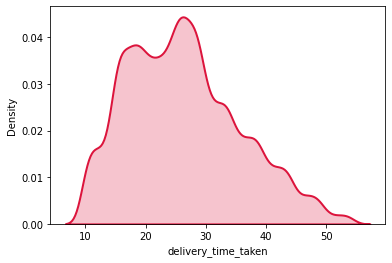

In [21]:
sns.kdeplot(data=variables_df, x=target, shade=True, color="crimson", lw=2)
plt.show()

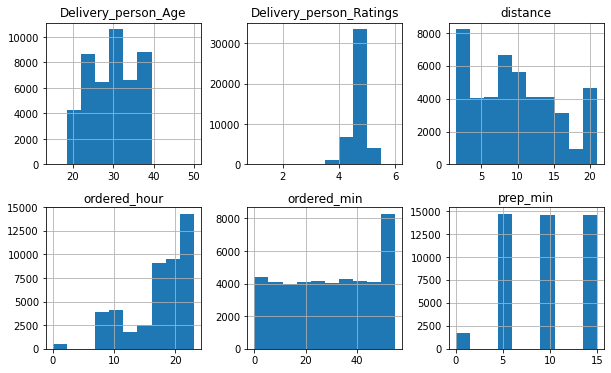

In [22]:
variables_df[numerical_features].hist(layout=(2,3), figsize=(10,6))
plt.show()

The distributions of numerical features not seem normally distributed, so as a standardization method we will use MinMax (0-1) scaling

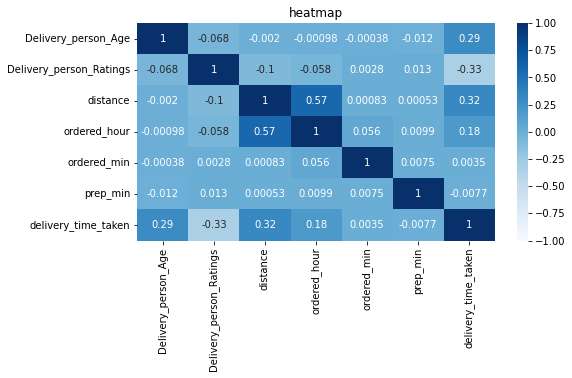

In [23]:
plt.figure(figsize=(8,4))

corr_matrix = variables_df[numerical_features+[target]].corr()
matrix = np.triu(corr_matrix)

sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1, cmap="Blues")
plt.title("heatmap")
plt.show()

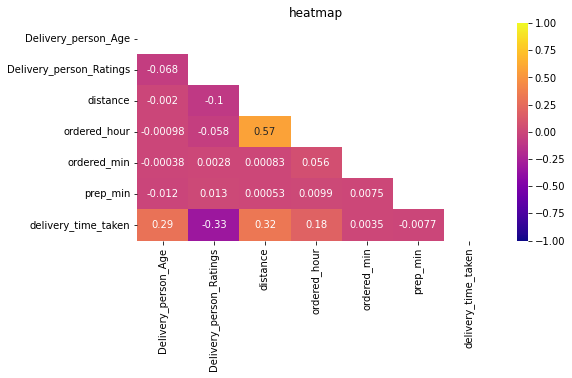

In [24]:
plt.figure(figsize=(8,4))

corr_matrix = variables_df[numerical_features+[target]].corr()
lower_matrix = np.triu(corr_matrix) #Print only lower correlation matrix since the correlation matrix is symmetric from diagonal.

sns.heatmap(corr_matrix, mask=lower_matrix, annot=True, vmin=-1, vmax=1, cmap="plasma")
plt.title("heatmap")
plt.show()

In [25]:
len(categorical_features)

11

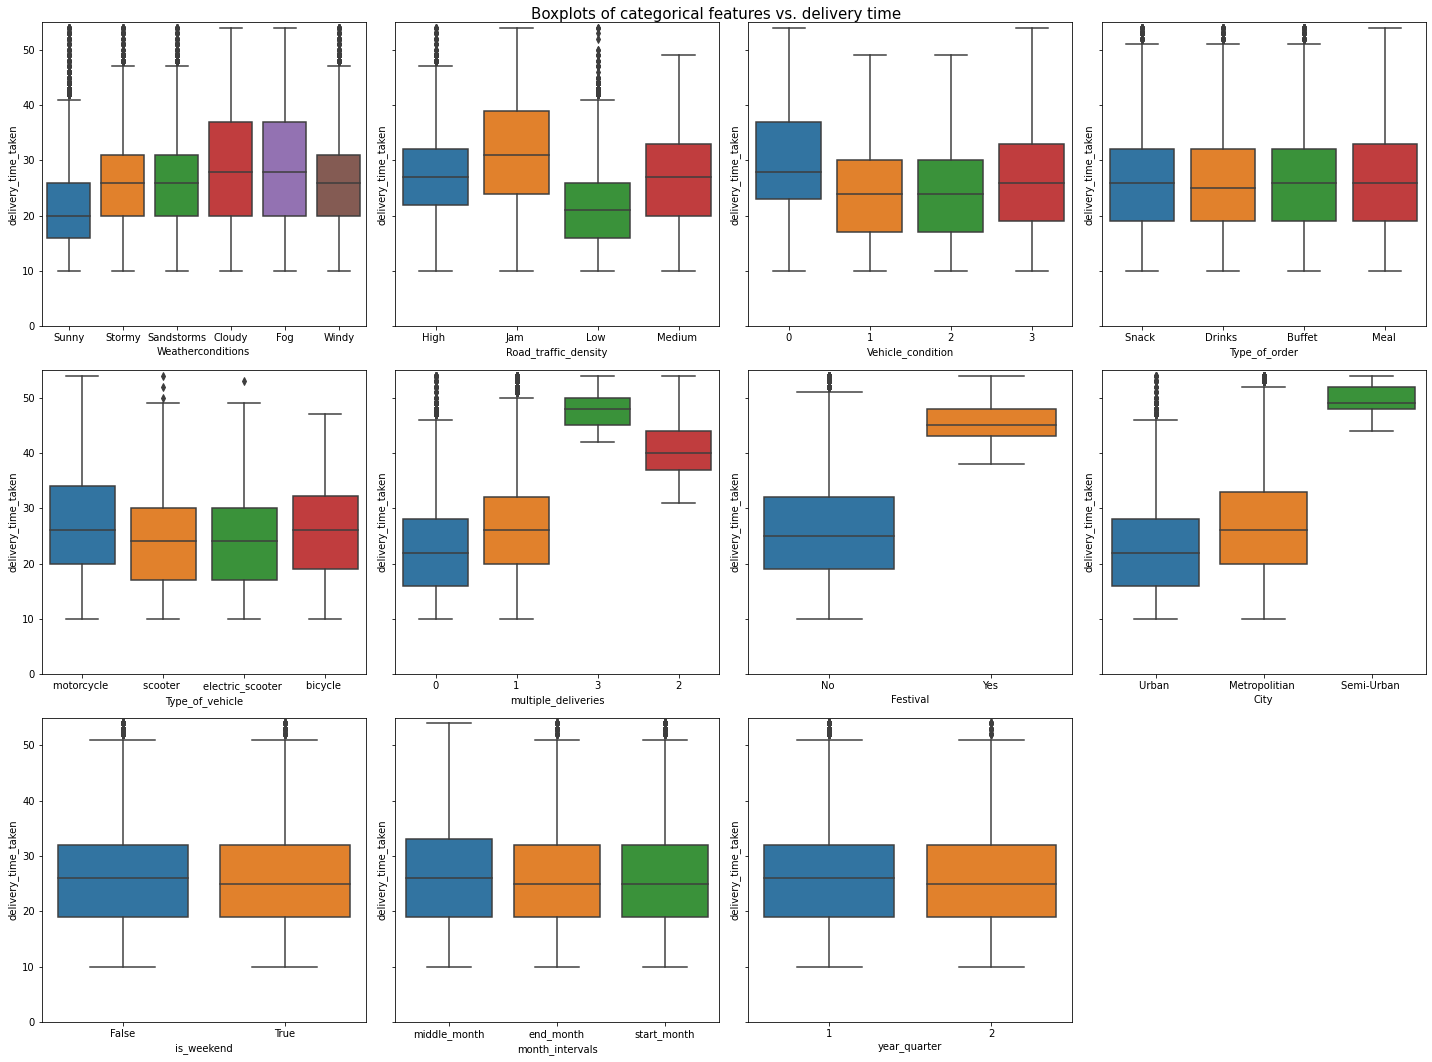

In [26]:
fig, ax = plt.subplots(3,4, figsize=(20,15), sharey=True)
fig.set_tight_layout(True)

row,col = 0,0

for var in categorical_features:
    sns.boxplot(data=variables_df, x=var, y=target, ax=ax[row,col])
    ax[row,col].set_ylim([0,55])

    if col < 3:
        col += 1 
    else:
        row += 1
        col = 0

fig.delaxes(ax[2,3]) #delete empty plot
fig.suptitle("Boxplots of categorical features vs. delivery time", fontsize=15)
plt.show()

### Multivariate Analysis

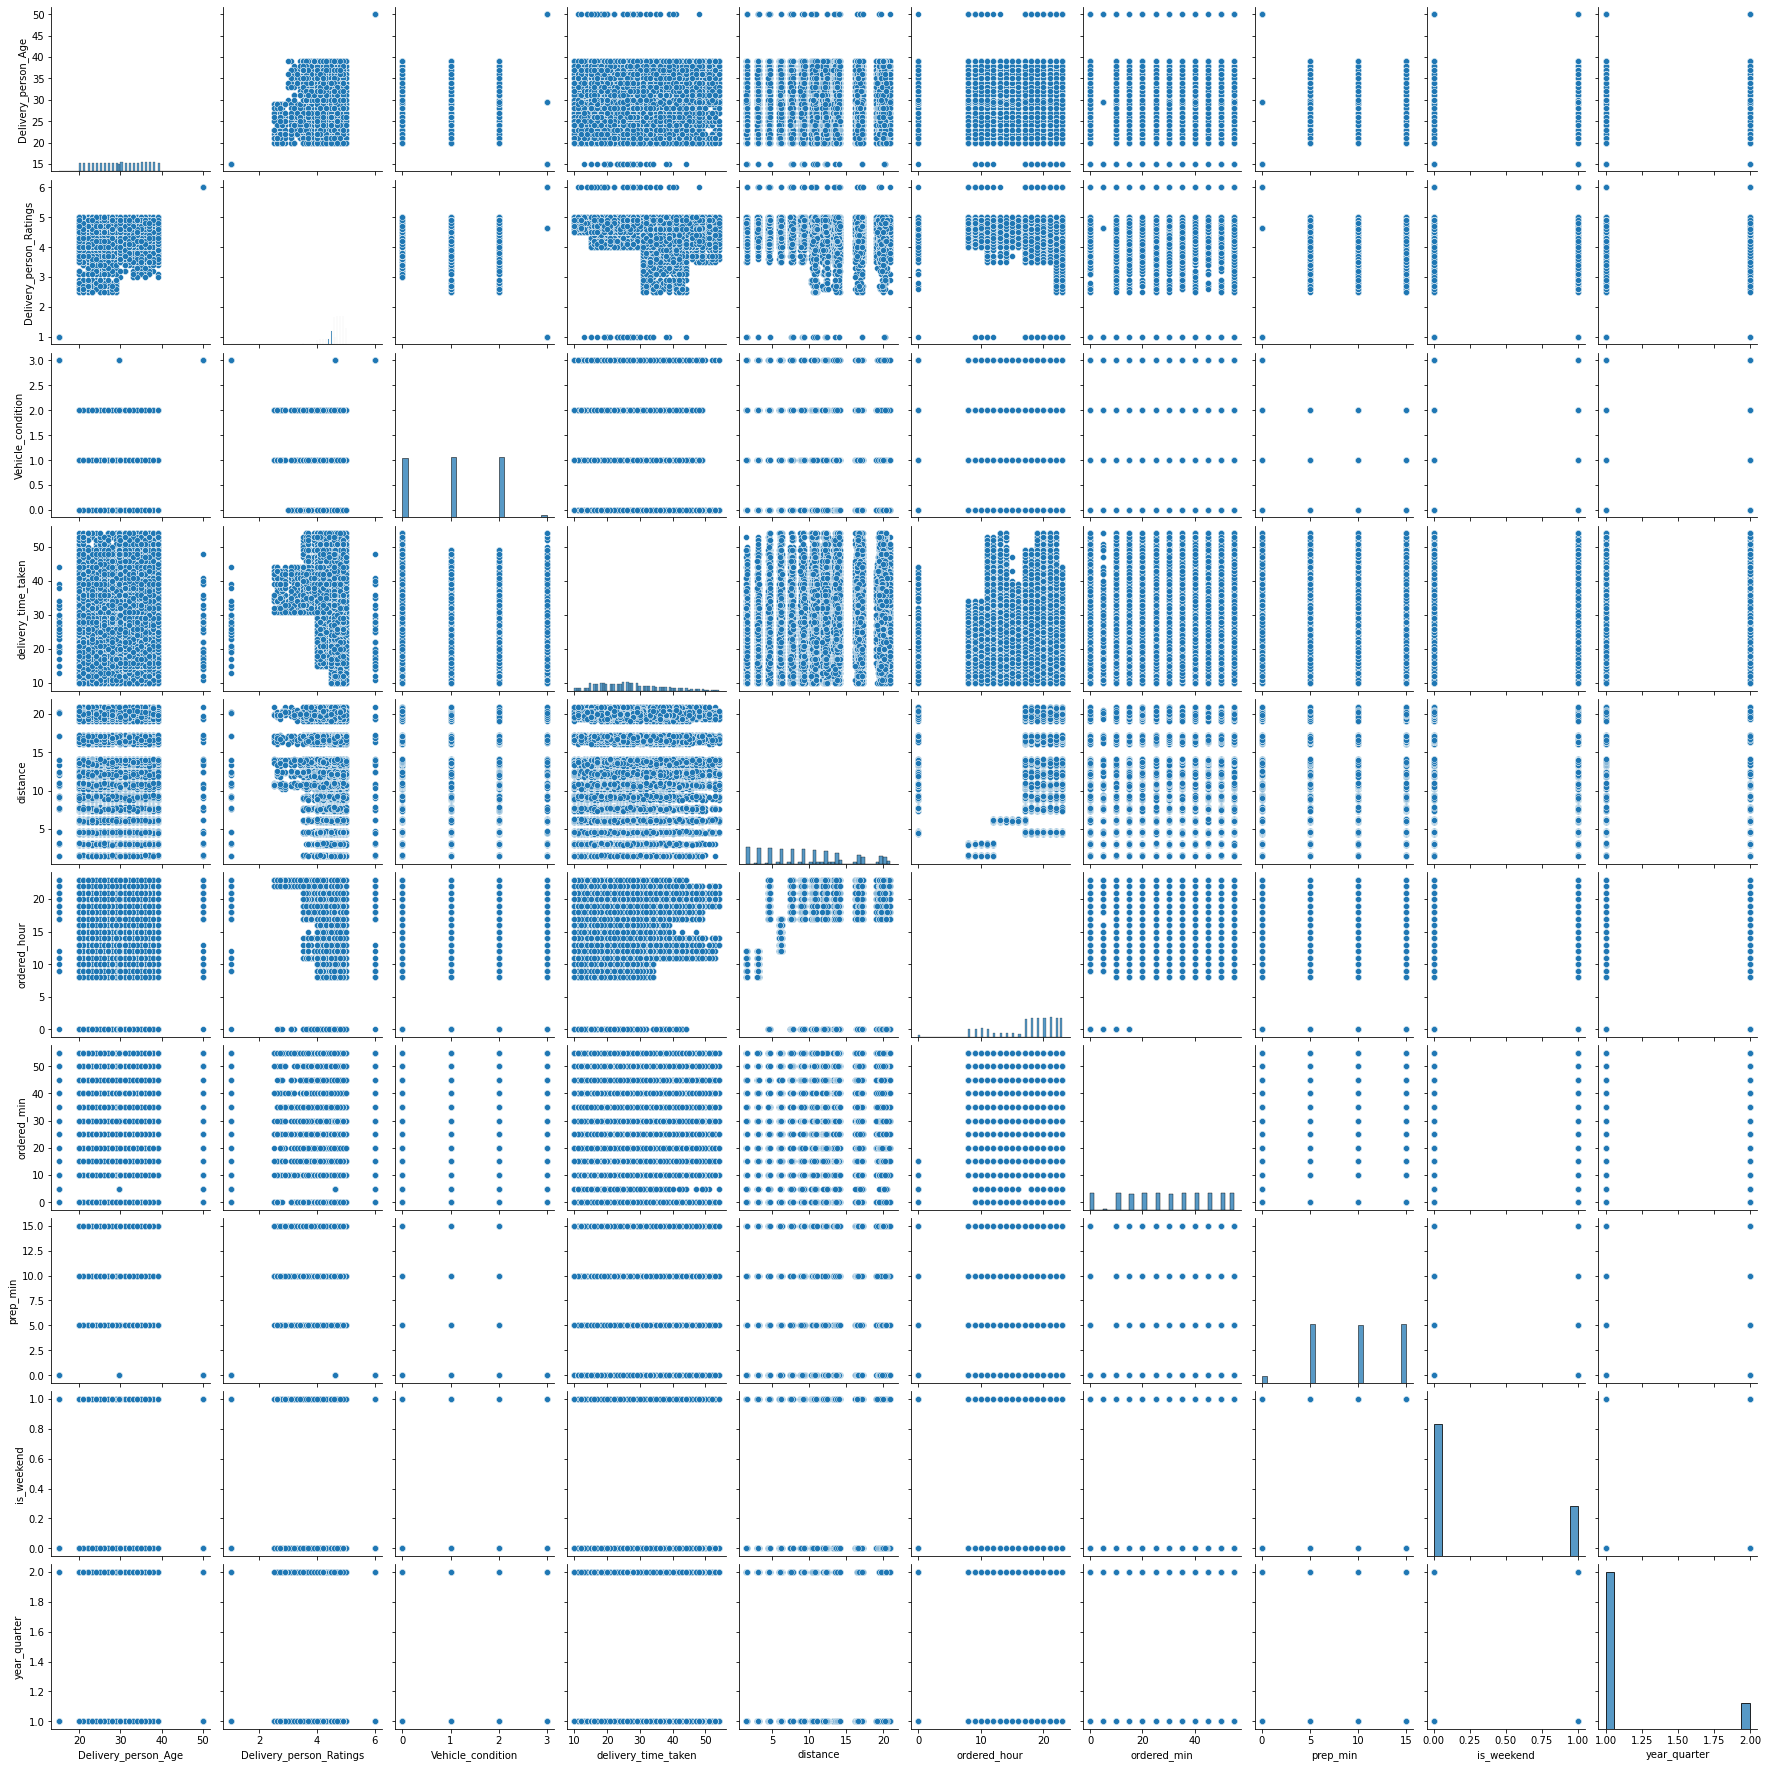

In [27]:
sns.pairplot(data=variables_df)
plt.show()

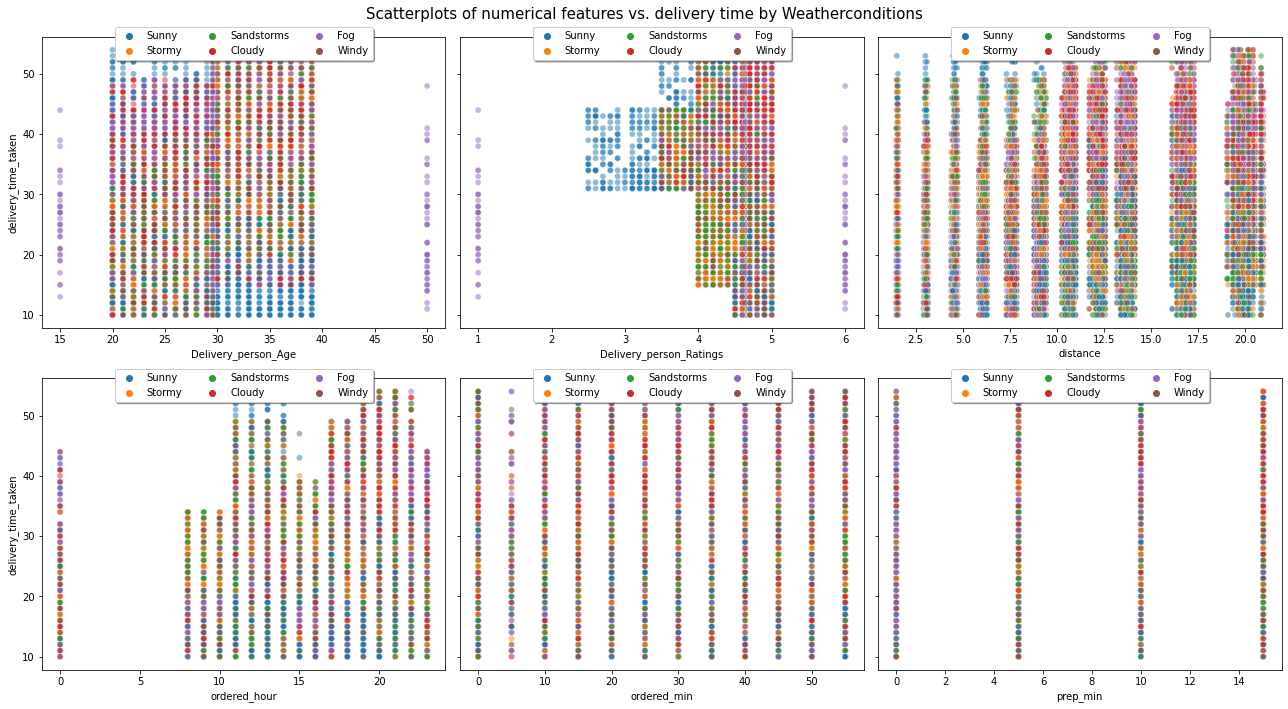

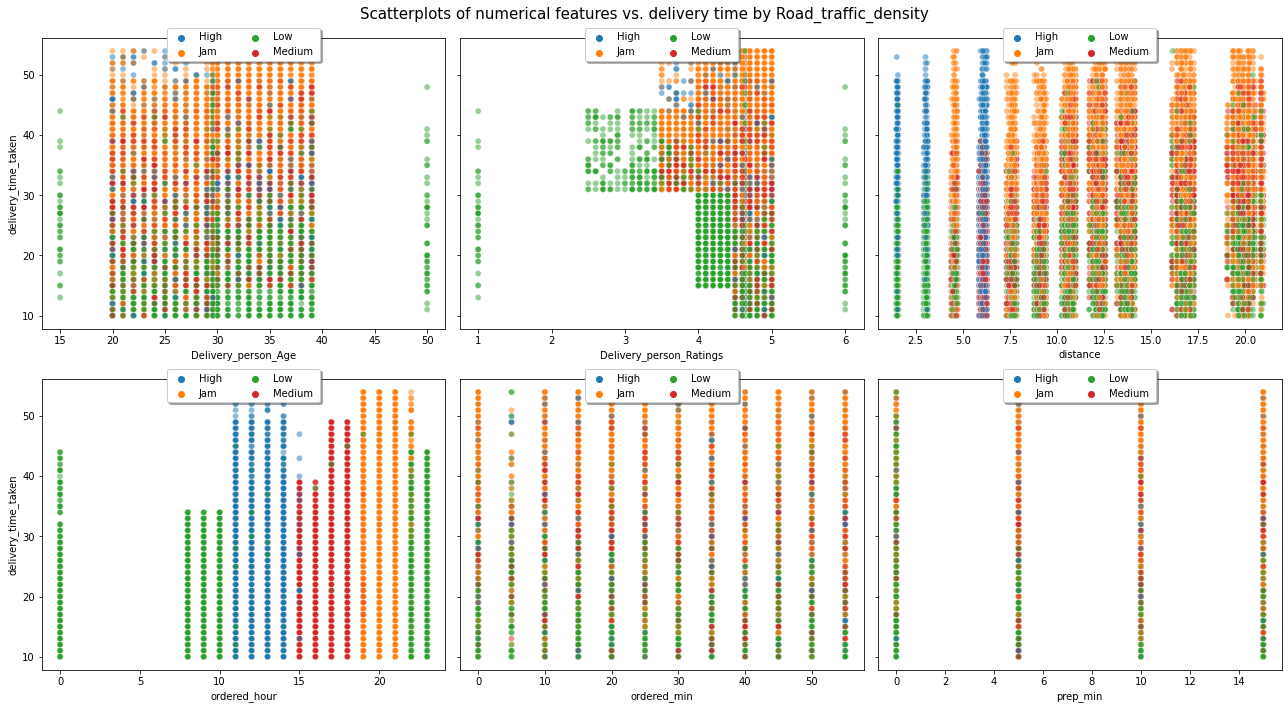

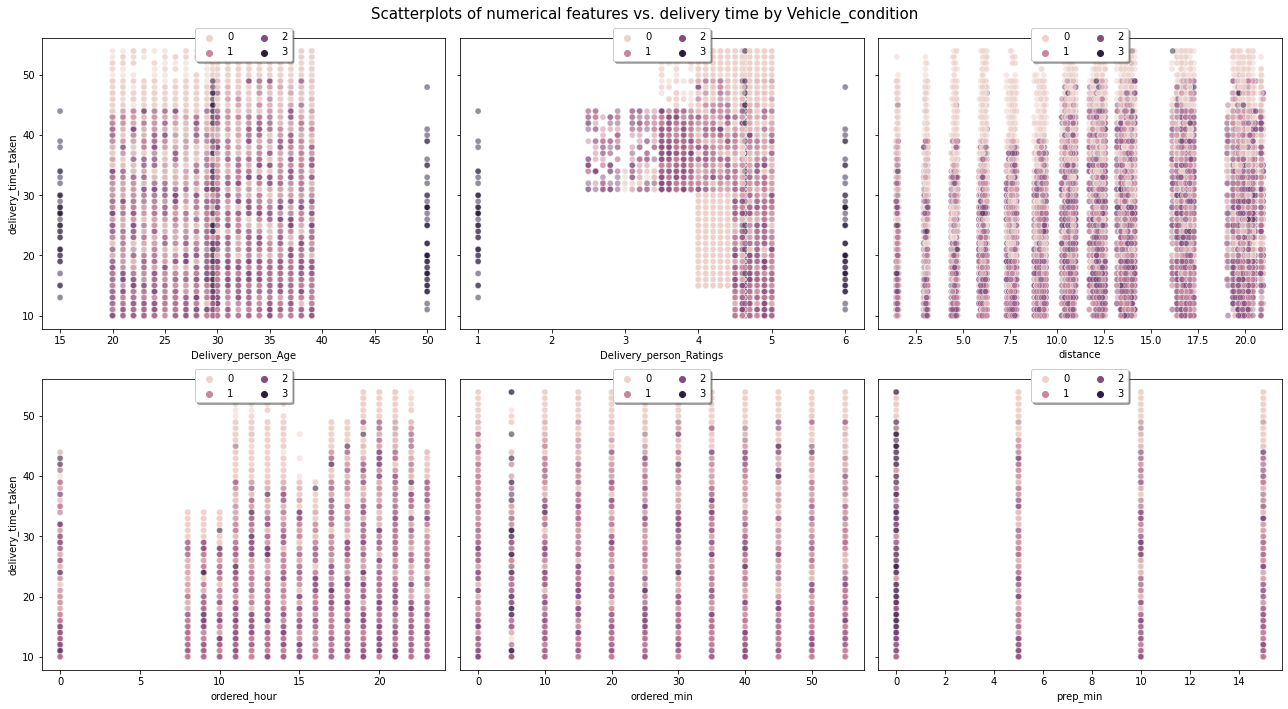

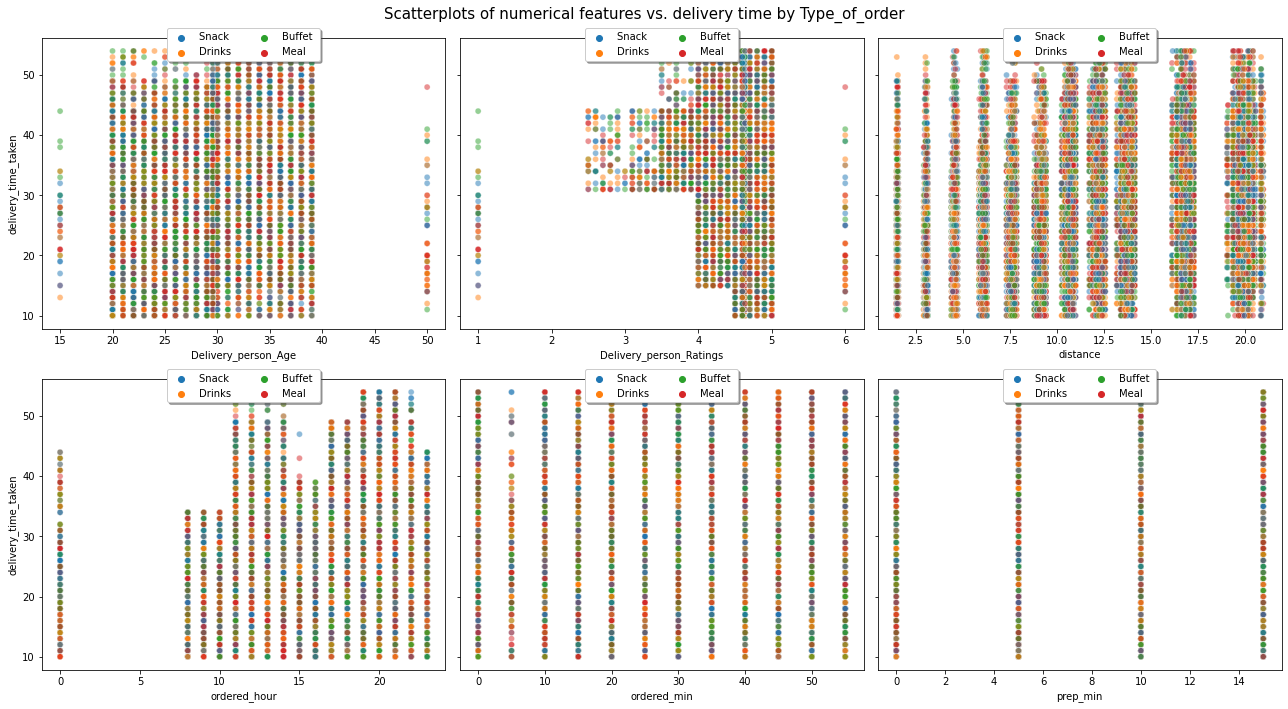

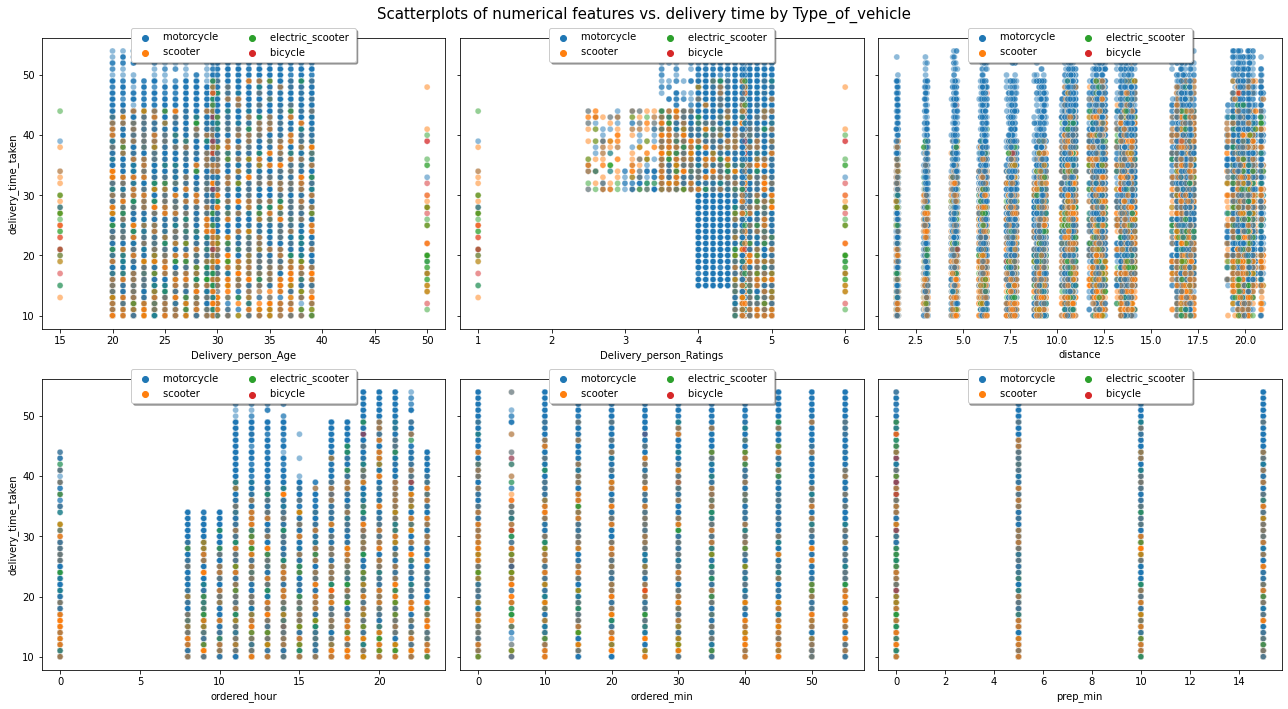

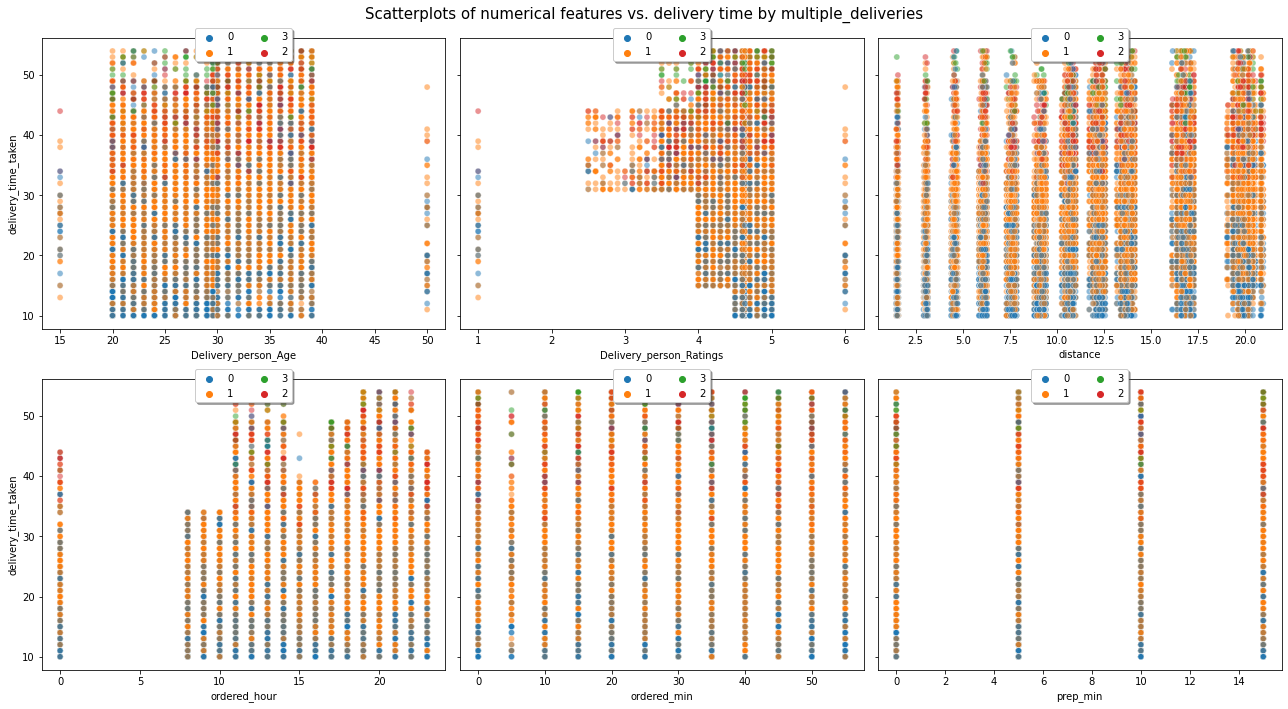

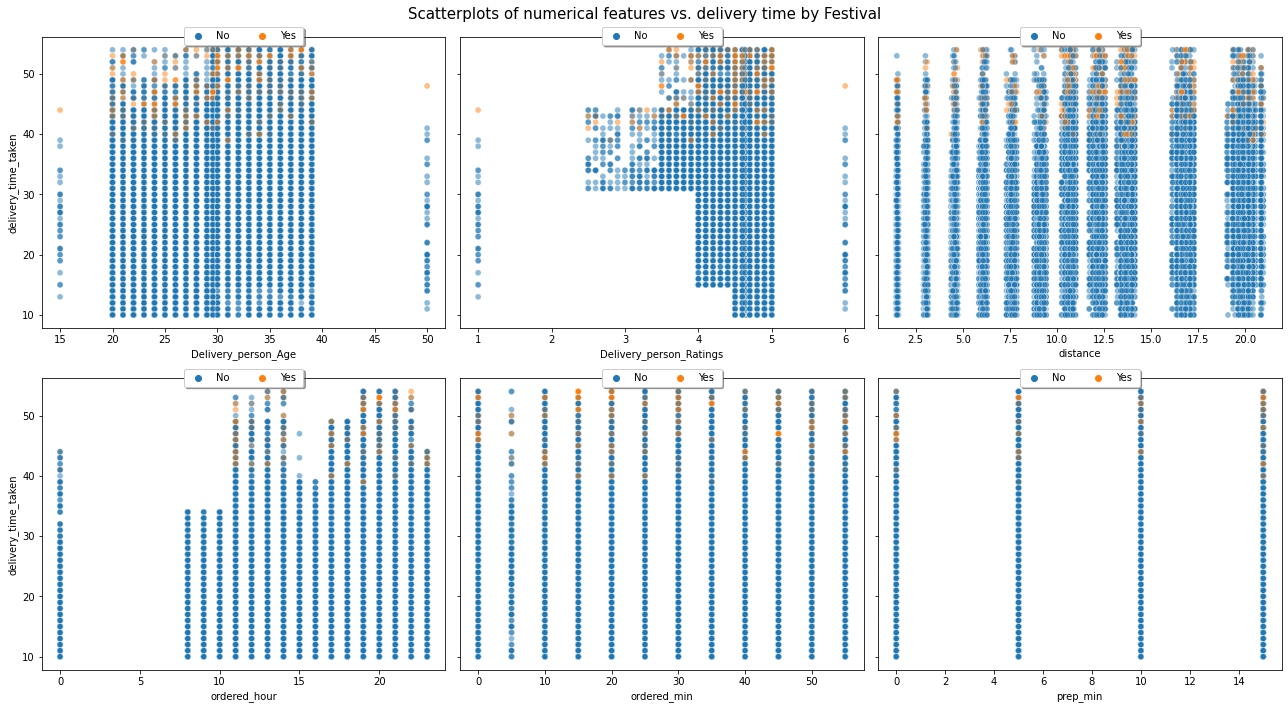

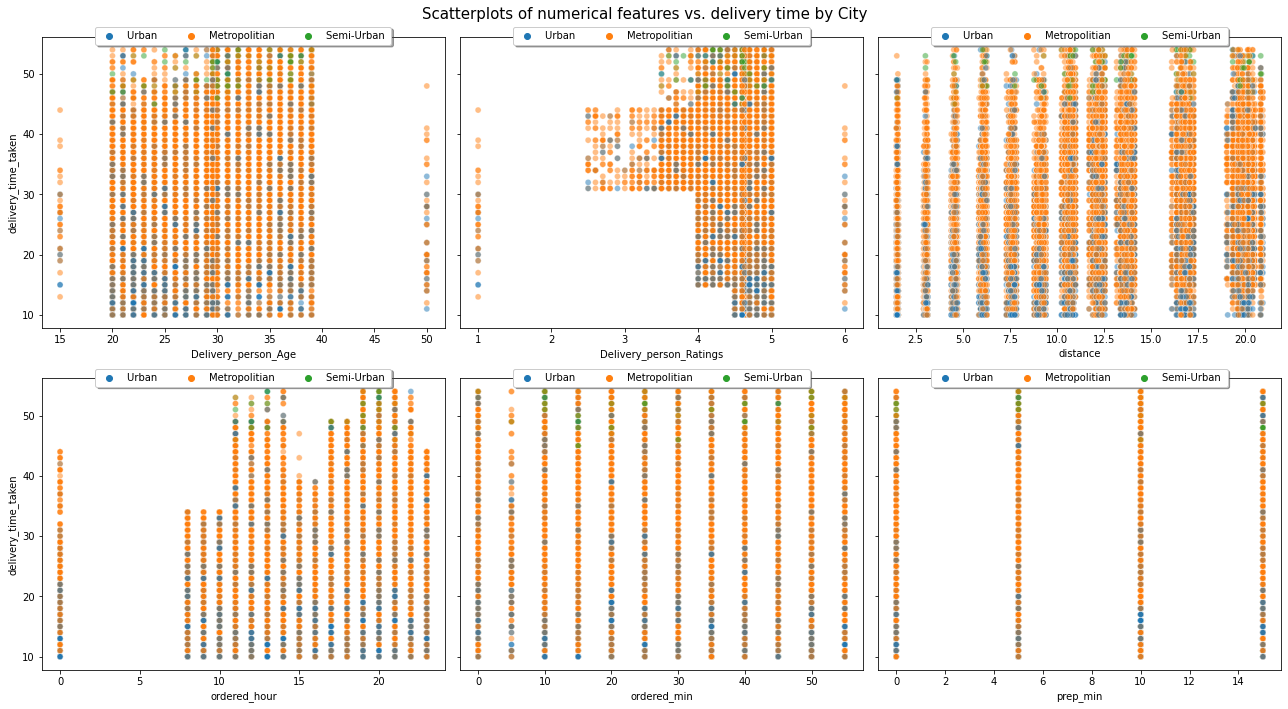

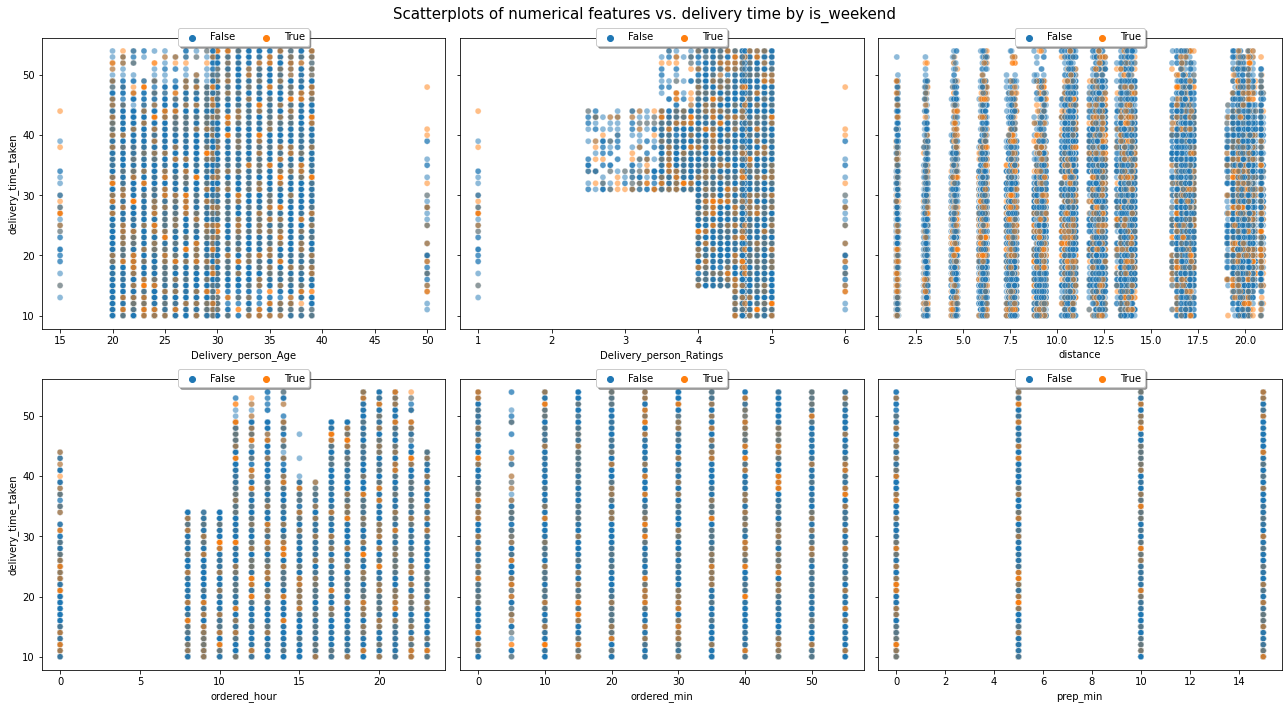

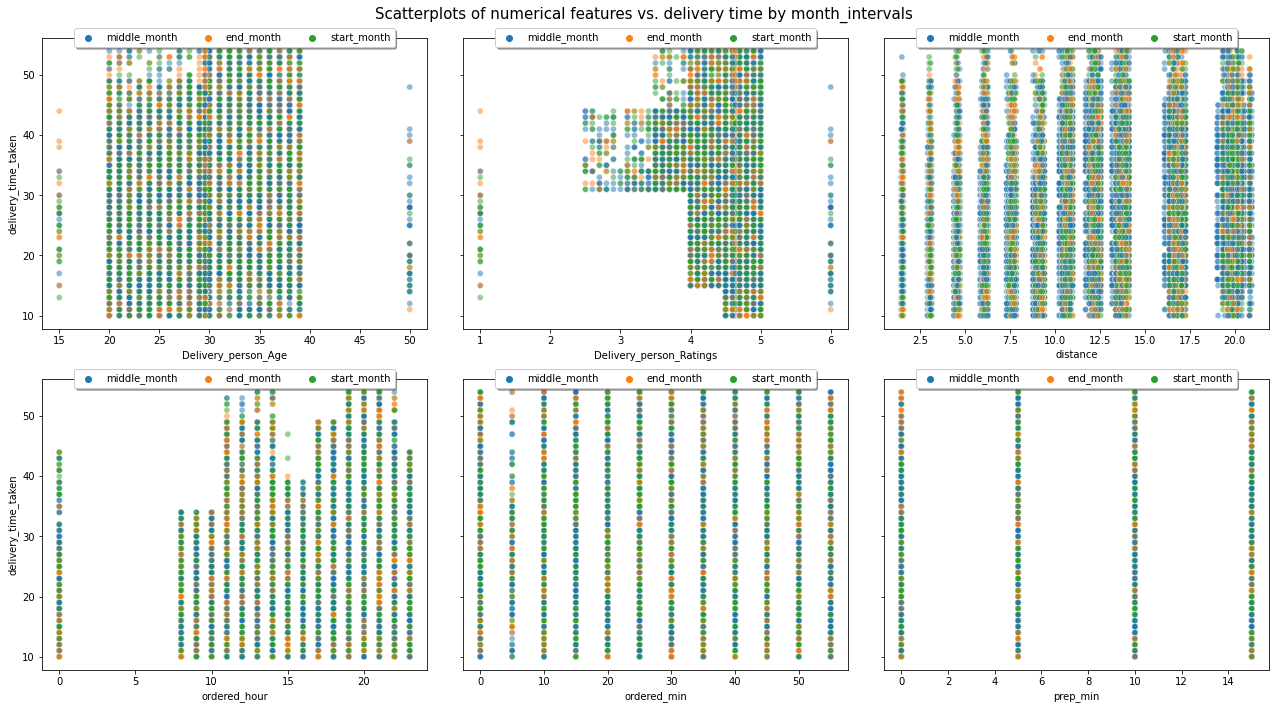

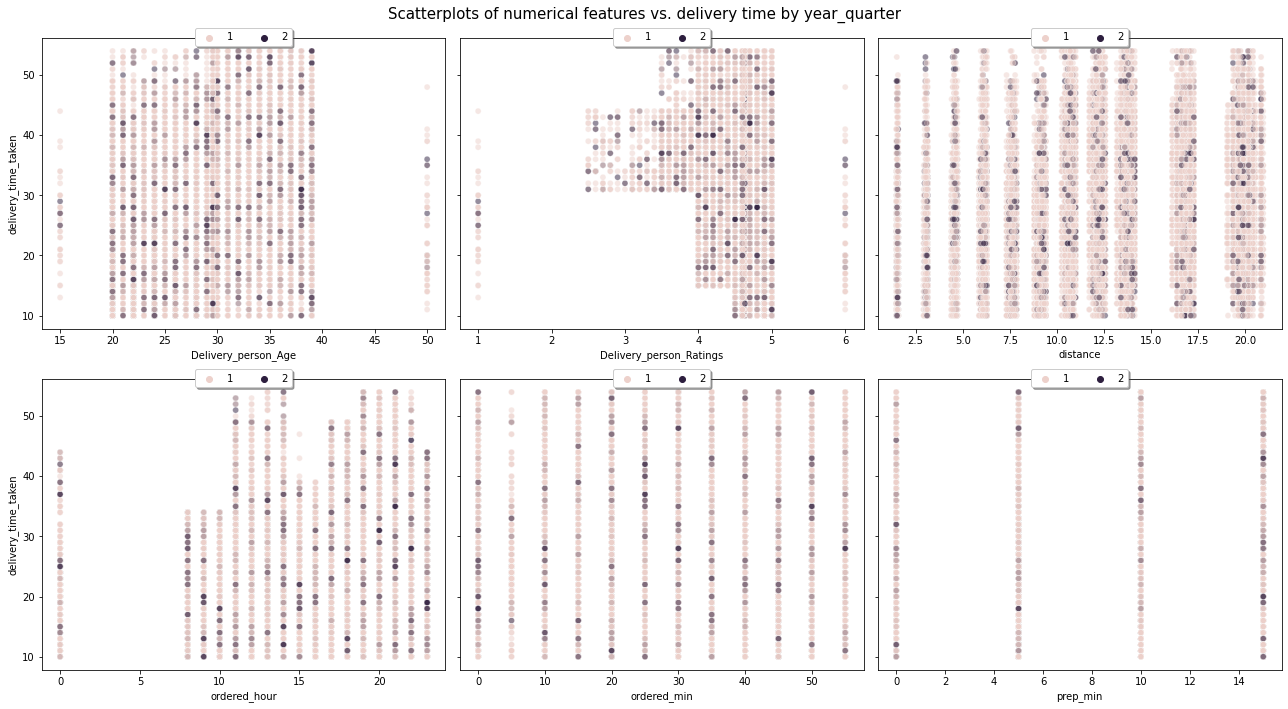

In [28]:
for category in categorical_features:
    fig, ax = plt.subplots(2,3, figsize=(18,10), sharey=True)
    fig.set_tight_layout(True)

    row,col = 0,0

    for var in numerical_features:
        sns.scatterplot(data=variables_df, x=var, y=target, hue=category, ax=ax[row,col], alpha=0.5)
        
        ax[row,col].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
                           fancybox=True, shadow=True, ncol=len(variables_df[category].unique()) 
                           if len(variables_df[category].unique()) < 4 else len(variables_df[category].unique())//2)
        
        if col < 2:
            col += 1 
        else:
            row += 1
            col = 0

    fig.suptitle(f'Scatterplots of numerical features vs. delivery time by {category}', fontsize=15)
    plt.show()

Analyze if delivery person's age or ratings change over delivery time by distance

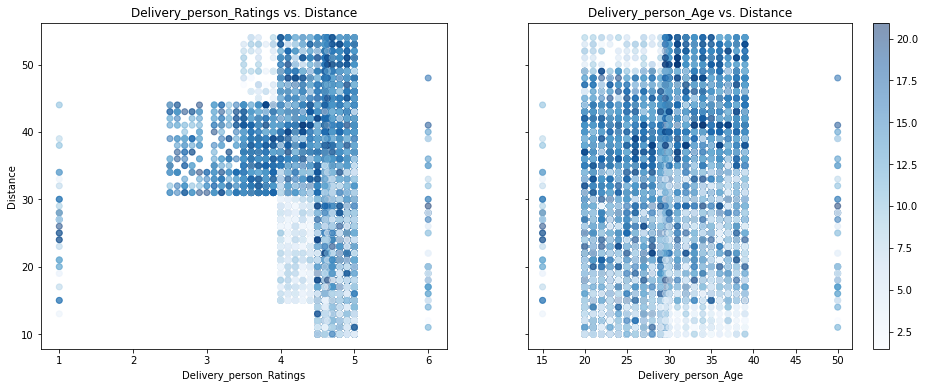

In [29]:
fig, ax = plt.subplots(1,2, figsize=(16,6), sharey=True)
cm = plt.cm.get_cmap('Blues')

for i,delivery in enumerate(["Delivery_person_Ratings", "Delivery_person_Age"]):
    plot = ax[i].scatter(x=variables_df[delivery], y=variables_df[target], c=variables_df["distance"], alpha=0.5, cmap=cm)
    ax[i].set_xlabel(delivery)
    ax[i].set_title(delivery + " vs. Distance")

ax[0].set_ylabel("Distance")
fig.colorbar(plot)
plt.show()

# 4) Model Training
- Train regression based machine learning models and make predictions
- Train deep learning models
- Make predictions and compare results
- Apply:
  - Standardization
  - Grid search cross-validaton for hyperparameter tuning
  - Hold-out method for test set
  - Examine feature importances

In [30]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost

Convert categorical feature values into numerical values by using LabelEncoder

In [31]:
label_enc = LabelEncoder()

for category in categorical_features:
    variables_df[category] = label_enc.fit_transform(variables_df[category])

X = variables_df[numerical_features + categorical_features]
y = variables_df[target]

Split as train and test sets by size of %33 and apply 0-1 scaling to the dataset

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)

scaler = MinMaxScaler()

for feature in X.columns:
    X_train[feature] = scaler.fit_transform(X_train[feature].to_numpy().reshape(-1,1))
    X_test[feature] = scaler.fit_transform(X_test[feature].to_numpy().reshape(-1,1))

Apply grid search to find best parameters and create baseline results for XGBoost, Random Forest, Ada Boost and Decision Tree  Regressor algorithms

In [36]:
baseline_scores = {}

#XGBoost
params = { 
        'max_depth': [3,6,10,50],
        'learning_rate': [0.005, 0.01, 0.05, 0.1],
        'n_estimators': [100, 250, 500, 1000]
        }

xgb = xgboost.XGBRegressor()
grid = GridSearchCV(estimator=xgb, 
                   param_grid=params,
                   scoring='neg_mean_squared_error'
                   )
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
print("Lowest RMSE: ", np.sqrt(-grid.best_score_))

baseline_scores["XGBoost"] = np.sqrt(-grid.best_score_)

Best parameters: {'learning_rate': 0.005, 'max_depth': 10, 'n_estimators': 1000}
Lowest RMSE:  3.8899011735060096


In [37]:
#Ada Boost
params = {
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 250, 500, 1000],
        'loss': ['linear', 'square', 'exponential']
        }

ada = AdaBoostRegressor()
grid = GridSearchCV(estimator=ada, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   )
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
print("Lowest RMSE: ", np.sqrt(-grid.best_score_))

baseline_scores["AdaBoost"] = np.sqrt(-grid.best_score_)

Best parameters: {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 250}
Lowest RMSE:  5.697759283565869


In [38]:
#Random Forest
params = { 
        'max_depth': [3, 6, 10, 50],
        'n_estimators': [100, 250, 500, 1000],
        'bootstrap': [True, False]
        }

rnd_forest = RandomForestRegressor()
grid = GridSearchCV(estimator=rnd_forest, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   )
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
print("Lowest RMSE: ", np.sqrt(-grid.best_score_))

baseline_scores["Random_Forest"] = np.sqrt(-grid.best_score_)

Best parameters: {'bootstrap': True, 'max_depth': 10, 'n_estimators': 500}
Lowest RMSE:  3.906905917929978


In [39]:
#Decision Tree
params = { 'max_depth': [3, 6, 10, 50],
           'splitter': ['best', 'random'],
           'min_samples_split': [2, 10, 25, 50]
           }

dec_tree = DecisionTreeRegressor()
grid = GridSearchCV(estimator=dec_tree, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   )
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
print("Lowest RMSE: ", np.sqrt(-grid.best_score_))

baseline_scores["Decision_Tree"] = np.sqrt(-grid.best_score_)

Best parameters: {'max_depth': 10, 'min_samples_split': 50, 'splitter': 'best'}
Lowest RMSE:  4.02028128775585


In [40]:
out_file = open('baseline_scores.json', 'w') 
json.dump(baseline_scores, out_file, indent=6)
out_file.close()

Plot the performances of different algorithms and highlight the best one in terms of validation RMSE scores

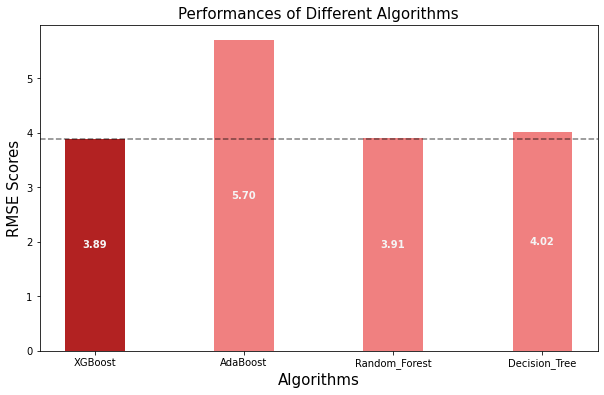

In [47]:
scores = list(baseline_scores.values())

fig, ax = plt.subplots(figsize=(10,6))

ind = np.arange(len(scores)) + 0.3
width = 0.4

bars = ax.bar(ind, scores, width, color="lightcoral")
ax.bar_label(bars, fmt='%.2f', weight='bold', label_type='center', color='whitesmoke')

ax.patches[scores.index(min(scores))].set_facecolor('firebrick') # Highlight the best performed algorithm

plt.axhline(min(scores), ls="--", alpha=0.5, color="black")

plt.xticks(ind, labels = baseline_scores.keys(), fontsize=10)
#plt.xticks(rotation=45)

plt.xlabel("Algorithms", fontsize=15)
plt.ylabel("RMSE Scores", fontsize=15)
plt.title("Performances of Different Algorithms", fontsize=15)

plt.show()

# 5. Testing and Results
- Fit the best trained models on test sets
- Compare algorithm performances on test the set
- Plot residuals
- Investigate feature importances and find most relevant features

Compare performances of algorithms on test sets with the best parameters by using 5-Fold Cross Validation with Hold-out method of the test set.

In [33]:
#Best Parameters for each algorithm
xgb = xgboost.XGBRegressor(learning_rate = 0.05, max_depth = 10, n_estimators = 1000)
ada_boost = AdaBoostRegressor(learning_rate = 0.1, loss = 'exponential', n_estimators = 250)
rnd_forest = RandomForestRegressor(max_depth = 10, n_estimators = 500, bootstrap=True)
dec_tree = DecisionTreeRegressor(max_depth = 10, min_samples_split = 50, splitter = 'best')

algorithms = {
            'XGBoost': xgb,
            'AdaBoost': ada_boost,
            'Random Forest': rnd_forest,
            'Decision Tree': dec_tree
            }

In [34]:
rmse_scores, r2_scores = {}, {}

for algorithm, model in algorithms.items():

    model.fit(X_train, y_train)
    pred = model.predict(X_test).reshape(-1,1)

    rmse_scores[algorithm] = mean_squared_error(y_test,pred)**(0.5)
    r2_scores[algorithm] = r2_score(y_test, pred)

Predictions and results on test set

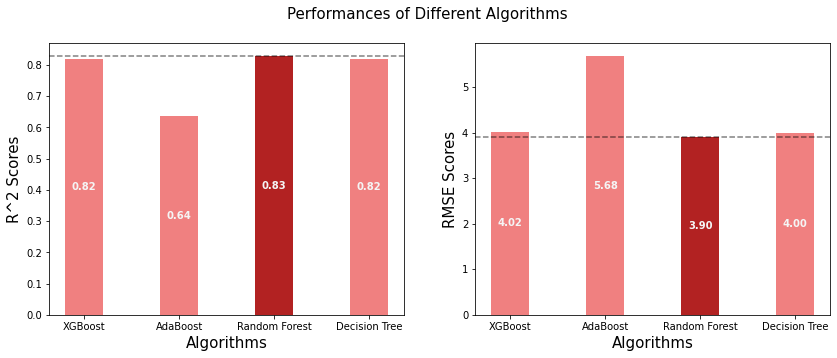

In [35]:
fig, ax = plt.subplots(1,2,figsize=(14,5))

ind = np.arange(len(r2_scores)) + 0.3
width = 0.4

for i,score_dict in enumerate([r2_scores, rmse_scores]): 
    scores = list(score_dict.values())

    bars = ax[i].bar(ind, scores, width, color="lightcoral")
    ax[i].bar_label(bars, fmt='%.2f', weight='bold', label_type='center', color='whitesmoke')
    ax[i].patches[scores.index(max(scores)) if i==0 else scores.index(min(scores))].set_facecolor('firebrick') # Highlight the best resulted bar
    ax[i].axhline(max(scores) if i==0 else min(scores), ls="--", alpha=0.5, color="black") # Draw a dashed line of the best algorithm
    ax[i].set_xticks(ind, labels = score_dict.keys(), fontsize=10)
    ax[i].set_xlabel("Algorithms", fontsize=15)
    ax[i].set_ylabel("R^2 Scores" if i==0 else "RMSE Scores", fontsize=15)

fig.suptitle("Performances of Different Algorithms", fontsize=15)
plt.show()

Random Forest performed best on test sets in both R^2 score and RSME score
- XGBoost, Random Forest and Decision Tree performances are close to each other in regarding to R^2 Score performance
- Random Forest outperformed better in RMSE score than XGBoost and Decision Tree
- However, AdaBoost performed worst by far

### Residual Analysis

In [36]:
model = algorithms["Random Forest"]
model.fit(X_train, y_train)
pred = model.predict(X_test)

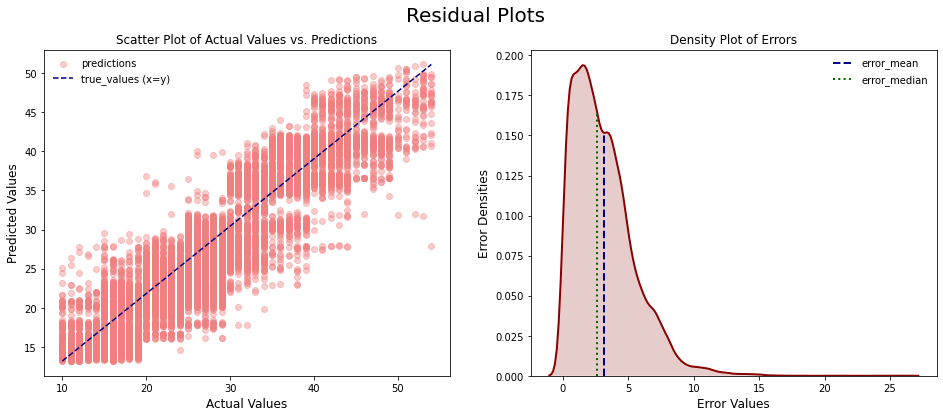

In [37]:
#Residual plots
fig, ax = plt.subplots(1,2,figsize=(16,6))

ax[0].scatter(x=y_test, y=pred, alpha=0.4, color="lightcoral", label="predictions")
ax[0].plot([min(y_test), max(y_test)], [min(pred), max(pred)], ls="dashed", color="navy", label="true_values (x=y)")
ax[0].legend(loc="best", frameon=False)

ax[0].set_xlabel("Actual Values", fontsize=12)
ax[0].set_ylabel("Predicted Values", fontsize=12)
ax[0].set_title("Scatter Plot of Actual Values vs. Predictions", fontsize=12)

errors = [np.abs(p-t) for p,t in zip(pred, y_test)]

ax[1] = sns.kdeplot(errors, shade=False, color="darkred", linewidth=2)

kdeline = ax[1].lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()

height = np.interp(np.mean(errors), xs, ys)
ax[1].vlines(np.mean(errors), 0, height, color='darkblue', ls='dashed', lw=2, label="error_mean")

height = np.interp(np.median(errors), xs, ys)
ax[1].vlines(np.median(errors), 0, height, color='darkgreen', ls='dotted', lw=2, label="error_median")

ax[1].fill_between(xs, 0, ys, facecolor='darkred', alpha=0.2)

ax[1].legend(loc="best", frameon=False)

ax[1].set_xlabel("Error Values", fontsize=12)
ax[1].set_ylabel("Error Densities", fontsize=12)
ax[1].set_title("Density Plot of Errors", fontsize=12)

fig.suptitle("Residual Plots", fontsize=20)
plt.show()

### Feature Importances

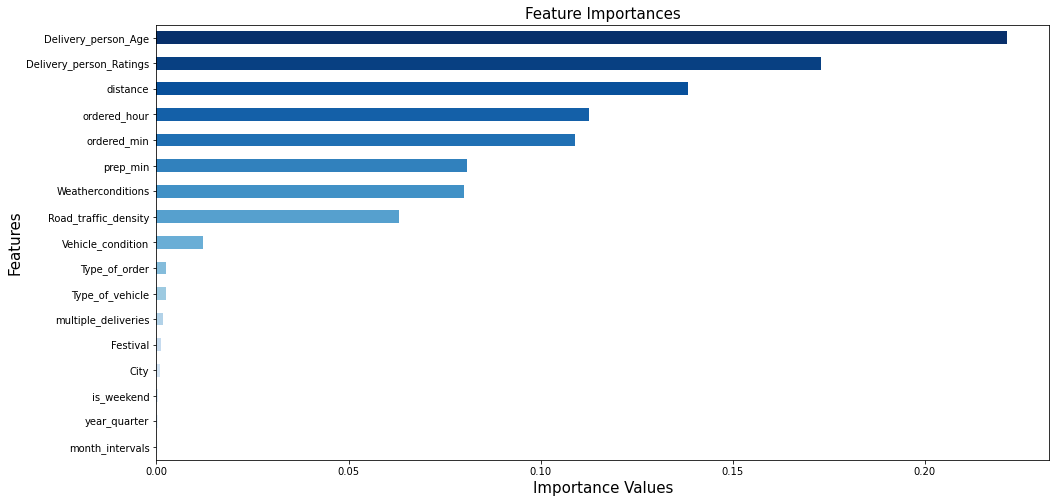

In [46]:
from mycolorpy import colorlist as mcp

imp = list(model.feature_importances_)

importances = pd.DataFrame({"feature": X_train.columns, "importance": imp})
importances = importances.sort_values(by="importance")

colors = mcp.gen_color(cmap='Blues', n=len(importances))

ax = importances.plot(kind='barh', x='feature', y='importance', figsize=(16,8), color=colors, legend=False)
plt.xlabel("Importance Values", fontsize=15)
plt.ylabel("Features", fontsize=15)
plt.title("Feature Importances", fontsize=15)
plt.show()

Let's investigate the relevant and irrelevant features

In [39]:
#Sort feature importances by descending order

importances = importances.sort_values(by="importance", ascending=False)
importances.reset_index(inplace=True, drop=True)
importances.head(3)


feature  importance
0  Delivery_person_Ratings    0.221244
1        Weatherconditions    0.173890
2      multiple_deliveries    0.138710

In [40]:
r2_scores_new = []
for feature_num in range(len(importances)):
    
    new_features = importances["feature"][:feature_num+1]

    X_train_new = X_train[new_features]
    X_test_new = X_test[new_features]

    model.fit(X_train_new, y_train)
    pred = model.predict(X_test_new).reshape(-1,1)

    r2_scores_new.append(r2_score(pred, y_test))

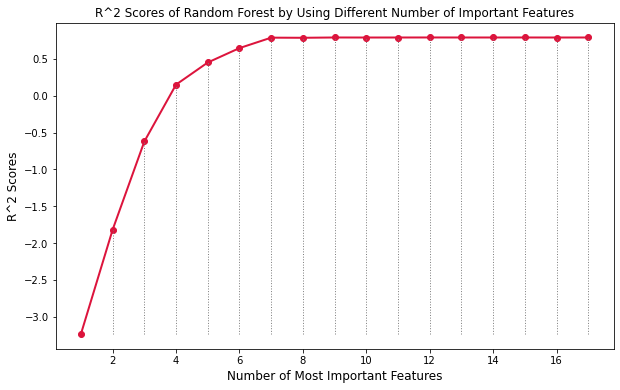

In [41]:
plt.figure(figsize=(10,6))

plt.plot(range(1,len(importances)+1), r2_scores_new, marker="o", lw=2, color="crimson")

plt.vlines(range(1,len(importances)+1), min(r2_scores_new), r2_scores_new, color='gray', ls='dotted', lw=1)

plt.xlabel("Number of Most Important Features", fontsize=12)
plt.ylabel("R^2 Scores", fontsize=12)
plt.title("R^2 Scores of Random Forest by Using Different Number of Important Features", fontsize=12)

plt.show()

It seems the most important 7 features are necessary for model to predict the delivery times. Other features are irrelevant for the model since adding them to model do not yield better results

In [42]:
#Relevant Features
importances[:7]

feature  importance
0  Delivery_person_Ratings    0.221244
1        Weatherconditions    0.173890
2      multiple_deliveries    0.138710
3     Road_traffic_density    0.111165
4                 distance    0.107830
5      Delivery_person_Age    0.080882
6        Vehicle_condition    0.080313